版权所有 (c) MONAI Consortium  
根据 Apache 许可证 2.0 版（以下简称“许可证”）授权许可；  
除非遵守许可证，否则你不能使用此文件。  
你可以在以下网址获得许可证副本：  
&nbsp;&nbsp;&nbsp;&nbsp;http://www.apache.org/licenses/LICENSE-2.0  
除非适用法律要求或书面同意，依据许可证分发的软件按“原样”分发，  
不附带任何明示或暗示的担保或条件。  
请参阅许可证以了解具体语言及权限限制。

# 使用 MedNIST 数据集的医学图像分类教程

在本教程中，我们介绍了一个基于 MedNIST 数据集的端到端训练和评估示例。

我们将进行以下步骤：
* 创建用于训练和测试的数据集
* 使用 MONAI 变换预处理数据
* 使用 MONAI 的 DenseNet 进行分类
* 使用 PyTorch 程序训练模型
* 在测试数据集上进行评估

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Project-MONAI/tutorials/blob/main/2d_classification/mednist_tutorial.ipynb)


## Setup environment

In [6]:
!python -c "import monai" || pip install -q "monai-weekly[pillow, tqdm]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

2024-12-25 01:47:08.353692: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-25 01:47:08.372039: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-25 01:47:08.377804: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-25 01:47:09.490207: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Setup imports

In [7]:
import os
import shutil
import tempfile
import matplotlib.pyplot as plt
import PIL
import torch
from torch.utils.tensorboard import SummaryWriter
import numpy as np
from sklearn.metrics import classification_report

from monai.apps import download_and_extract
from monai.config import print_config
from monai.data import decollate_batch, DataLoader
from monai.metrics import ROCAUCMetric
from monai.networks.nets import DenseNet121
from monai.transforms import (
    Activations,
    EnsureChannelFirst,
    AsDiscrete,
    Compose,
    LoadImage,
    RandFlip,
    RandRotate,
    RandZoom,
    ScaleIntensity,
)
from monai.utils import set_determinism

print_config()

MONAI version: 1.5.dev2451
Numpy version: 1.26.4
Pytorch version: 2.5.1+cu121
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 7c1c58cd10db72c01b5cdda1600cd68e262437cf
MONAI __file__: /usr/local/lib/python3.10/dist-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.3.2
scikit-image version: 0.25.0
scipy version: 1.13.1
Pillow version: 11.0.0
Tensorboard version: 2.17.1
gdown version: 5.2.0
TorchVision version: 0.20.1+cu121
tqdm version: 4.67.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.5
pandas version: 2.2.2
einops version: 0.8.0
transformers version: 4.47.1
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.i

## 设置数据目录

你可以使用 `MONAI_DATA_DIRECTORY` 环境变量指定一个目录。  
这允许你保存结果并重用下载内容。  
如果未指定，将使用临时目录。

In [8]:
# 定义数据目录的环境变量名称
DATA_DIR_ENV_VAR = "MONAI_DATA_DIRECTORY"

# 尝试获取用户指定的数据目录
data_dir = os.environ.get(DATA_DIR_ENV_VAR)

# 如果用户未指定，则创建临时目录
if data_dir is None:
    data_dir = tempfile.mkdtemp()
    print(f"未设置 {DATA_DIR_ENV_VAR} 环境变量，使用临时目录: {data_dir}")
else:
    # 确保用户指定的目录存在
    os.makedirs(data_dir, exist_ok=True)
    print(f"使用用户指定的数据目录: {data_dir}")

未设置 MONAI_DATA_DIRECTORY 环境变量，使用临时目录: /tmp/tmpwu96p80w


## 下载数据集

MedNIST 数据集是从 [TCIA](https://wiki.cancerimagingarchive.net/display/Public/Data+Usage+Policies+and+Restrictions)、[RSNA Bone Age Challenge](http://rsnachallenges.cloudapp.net/competitions/4) 和 [NIH Chest X-ray 数据集](https://cloud.google.com/healthcare/docs/resources/public-datasets/nih-chest) 中收集的。

该数据集由 [Dr. Bradley J. Erickson M.D., Ph.D.](https://www.mayo.edu/research/labs/radiology-informatics/overview)（梅奥诊所放射科）在 Creative Commons [CC BY-SA 4.0 许可证](https://creativecommons.org/licenses/by-sa/4.0/) 下提供。

如果你使用 MedNIST 数据集，请注明来源。

In [11]:
resource = "https://github.com/Project-MONAI/MONAI-extra-test-data/releases/download/0.8.1/MedNIST.tar.gz"
md5 = "0bc7306e7427e00ad1c5526a6677552d"
compressed_file = os.path.join(data_dir, "MedNIST.tar.gz")
dataset_dir = os.path.join(data_dir, "MedNIST")

if not os.path.exists(dataset_dir):
    download_and_extract(resource, compressed_file, data_dir, md5)

MedNIST.tar.gz: 59.0MB [00:01, 40.5MB/s]                            

2024-12-25 01:49:06,383 - INFO - Downloaded: /tmp/tmpwu96p80w/MedNIST.tar.gz


2024-12-25 01:49:06,655 - INFO - Verified 'MedNIST.tar.gz', md5: 0bc7306e7427e00ad1c5526a6677552d.
2024-12-25 01:49:06,664 - INFO - Writing into directory: /tmp/tmpwu96p80w.


## 设置确定性训练以确保可重复性

希望这对你有帮助！如果你有更多问题或需要进一步的详细信息，请随时告诉我。

In [12]:
set_determinism(seed=0)

## 从数据集文件夹中读取图像文件名

首先，检查数据集文件并显示一些统计信息。  
数据集中有 6 个文件夹：Hand、AbdomenCT、CXR、ChestCT、BreastMRI、HeadCT，  
这些文件夹应作为标签来训练我们的分类模型。

In [14]:
class_names = sorted(x for x in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, x)))
num_class = len(class_names)

# Modified to include only image files
image_files = [
    [os.path.join(dataset_dir, class_names[i], x)
     for x in os.listdir(os.path.join(dataset_dir, class_names[i]))
     if os.path.isfile(os.path.join(dataset_dir, class_names[i], x))]  # Filter for files
    for i in range(num_class)
]

num_each = [len(image_files[i]) for i in range(num_class)]
image_files_list = []
image_class = []
for i in range(num_class):
    image_files_list.extend(image_files[i])
    image_class.extend([i] * num_each[i])
num_total = len(image_class)
image_width, image_height = PIL.Image.open(image_files_list[0]).size

print(f"Total image count: {num_total}")
print(f"Image dimensions: {image_width} x {image_height}")
print(f"Label names: {class_names}")
print(f"Label counts: {num_each}")

Total image count: 58954
Image dimensions: 64 x 64
Label names: ['AbdomenCT', 'BreastMRI', 'CXR', 'ChestCT', 'Hand', 'HeadCT']
Label counts: [10000, 8954, 10000, 10000, 10000, 10000]


## 随机从数据集中选择图像进行可视化和检查：

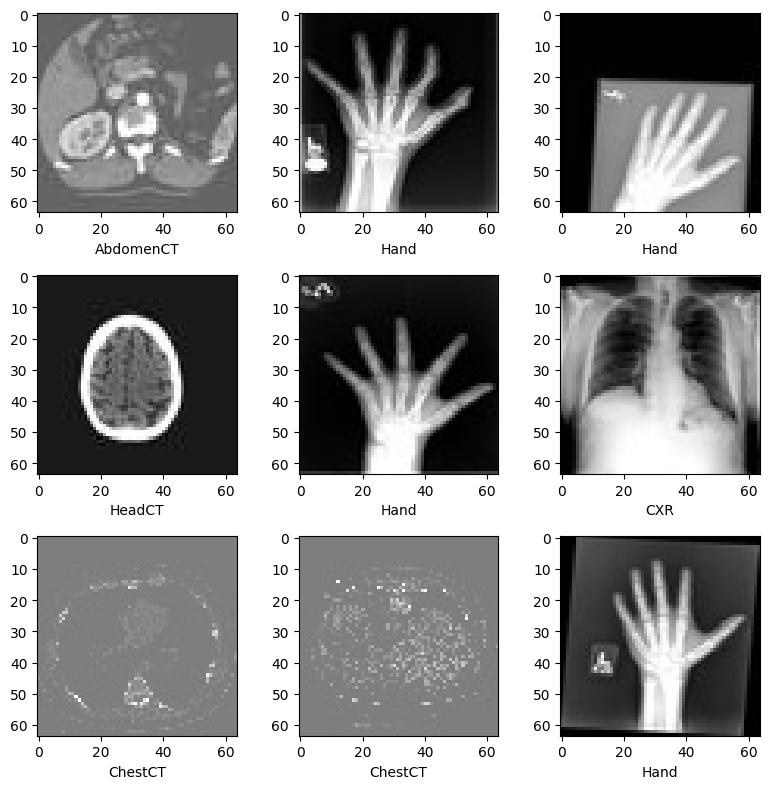

In [15]:
plt.subplots(3, 3, figsize=(8, 8))
for i, k in enumerate(np.random.randint(num_total, size=9)):
    im = PIL.Image.open(image_files_list[k])
    arr = np.array(im)
    plt.subplot(3, 3, i + 1)
    plt.xlabel(class_names[image_class[k]])
    plt.imshow(arr, cmap="gray", vmin=0, vmax=255)
plt.tight_layout()
plt.show()

## 准备训练、验证和测试数据列表

随机选择 10% 的数据集作为验证集，10% 作为测试集。

In [16]:
val_frac = 0.1
test_frac = 0.1
length = len(image_files_list)
indices = np.arange(length)
np.random.shuffle(indices)

test_split = int(test_frac * length)
val_split = int(val_frac * length) + test_split
test_indices = indices[:test_split]
val_indices = indices[test_split:val_split]
train_indices = indices[val_split:]

train_x = [image_files_list[i] for i in train_indices]
train_y = [image_class[i] for i in train_indices]
val_x = [image_files_list[i] for i in val_indices]
val_y = [image_class[i] for i in val_indices]
test_x = [image_files_list[i] for i in test_indices]
test_y = [image_class[i] for i in test_indices]

print(f"Training count: {len(train_x)}, Validation count: " f"{len(val_x)}, Test count: {len(test_x)}")

Training count: 47164, Validation count: 5895, Test count: 5895


## 定义 MONAI 变换、数据集和数据加载器以预处理数据

希望这对你有帮助！如果你有更多问题或需要进一步的详细信息，请随时告诉我。

In [17]:
train_transforms = Compose(
    [
        LoadImage(image_only=True),
        EnsureChannelFirst(),
        ScaleIntensity(),
        RandRotate(range_x=np.pi / 12, prob=0.5, keep_size=True),
        RandFlip(spatial_axis=0, prob=0.5),
        RandZoom(min_zoom=0.9, max_zoom=1.1, prob=0.5),
    ]
)

val_transforms = Compose([LoadImage(image_only=True), EnsureChannelFirst(), ScaleIntensity()])

y_pred_trans = Compose([Activations(softmax=True)])
y_trans = Compose([AsDiscrete(to_onehot=num_class)])

In [18]:
class MedNISTDataset(torch.utils.data.Dataset):
    def __init__(self, image_files, labels, transforms):
        self.image_files = image_files
        self.labels = labels
        self.transforms = transforms

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        return self.transforms(self.image_files[index]), self.labels[index]


train_ds = MedNISTDataset(train_x, train_y, train_transforms)
train_loader = DataLoader(train_ds, batch_size=300, shuffle=True, num_workers=10)

val_ds = MedNISTDataset(val_x, val_y, val_transforms)
val_loader = DataLoader(val_ds, batch_size=300, num_workers=10)

test_ds = MedNISTDataset(test_x, test_y, val_transforms)
test_loader = DataLoader(test_ds, batch_size=300, num_workers=10)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


## 定义网络和优化器

1. 设置每批次模型更新的学习率。
1. 设置总的训练轮数，因为我们有随机打乱和随机变换，所以每个轮次的训练数据都是不同的。  
   由于这是一个入门教程，我们只训练 4 个轮次。  
   如果训练 10 个轮次，模型可以在测试数据集上达到 100% 的准确率。
1. 使用 MONAI 的 DenseNet 并移动到 GPU 设备上，这个 DenseNet 可以支持 2D 和 3D 分类任务。
1. 使用 Adam 优化器。

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DenseNet121(spatial_dims=2, in_channels=1, out_channels=num_class).to(device)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 1e-5)
max_epochs = 4
val_interval = 1
auc_metric = ROCAUCMetric()

## 模型训练

执行一个典型的 PyTorch 训练，运行 epoch 循环和 step 循环，并在每个 epoch 后进行验证。  
如果获得最佳验证准确性，将保存模型权重到文件中。

希望这对你有帮助！如果你有更多问题或需要进一步的详细信息，请随时告诉我。

In [21]:
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
writer = SummaryWriter()

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(f"{step}/{len(train_ds) // train_loader.batch_size}, " f"train_loss: {loss.item():.4f}")
        epoch_len = len(train_ds) // train_loader.batch_size
        writer.add_scalar("train_loss", loss.item(), epoch_len * epoch + step)
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            y_pred = torch.tensor([], dtype=torch.float32, device=device)
            y = torch.tensor([], dtype=torch.long, device=device)
            for val_data in val_loader:
                val_images, val_labels = (
                    val_data[0].to(device),
                    val_data[1].to(device),
                )
                y_pred = torch.cat([y_pred, model(val_images)], dim=0)
                y = torch.cat([y, val_labels], dim=0)
            y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
            y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
            auc_metric(y_pred_act, y_onehot)
            result = auc_metric.aggregate()
            auc_metric.reset()
            del y_pred_act, y_onehot
            metric_values.append(result)
            acc_value = torch.eq(y_pred.argmax(dim=1), y)
            acc_metric = acc_value.sum().item() / len(acc_value)
            if result > best_metric:
                best_metric = result
                best_metric_epoch = epoch + 1
                # Changed root_dir to data_dir
                torch.save(model.state_dict(), os.path.join(data_dir, "best_metric_model.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current AUC: {result:.4f}"
                f" current accuracy: {acc_metric:.4f}"
                f" best AUC: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )
            writer.add_scalar("val_accuracy", acc_metric, epoch + 1)

print(f"train completed, best_metric: {best_metric:.4f} " f"at epoch: {best_metric_epoch}")
writer.close()

----------
epoch 1/4
1/157, train_loss: 0.2125
2/157, train_loss: 0.2182
3/157, train_loss: 0.2489
4/157, train_loss: 0.2415
5/157, train_loss: 0.2152
6/157, train_loss: 0.2191
7/157, train_loss: 0.2085
8/157, train_loss: 0.2011
9/157, train_loss: 0.2523
10/157, train_loss: 0.2412
11/157, train_loss: 0.2180
12/157, train_loss: 0.2194
13/157, train_loss: 0.2181
14/157, train_loss: 0.1848
15/157, train_loss: 0.2013
16/157, train_loss: 0.2358
17/157, train_loss: 0.2050
18/157, train_loss: 0.2422
19/157, train_loss: 0.2085
20/157, train_loss: 0.2042
21/157, train_loss: 0.1947
22/157, train_loss: 0.2335
23/157, train_loss: 0.2019
24/157, train_loss: 0.1829
25/157, train_loss: 0.2666
26/157, train_loss: 0.2068
27/157, train_loss: 0.1861
28/157, train_loss: 0.2184
29/157, train_loss: 0.1714
30/157, train_loss: 0.1860
31/157, train_loss: 0.2170
32/157, train_loss: 0.1736
33/157, train_loss: 0.2027
34/157, train_loss: 0.1672
35/157, train_loss: 0.1734
36/157, train_loss: 0.2007
37/157, train_lo

## 绘制损失和指标

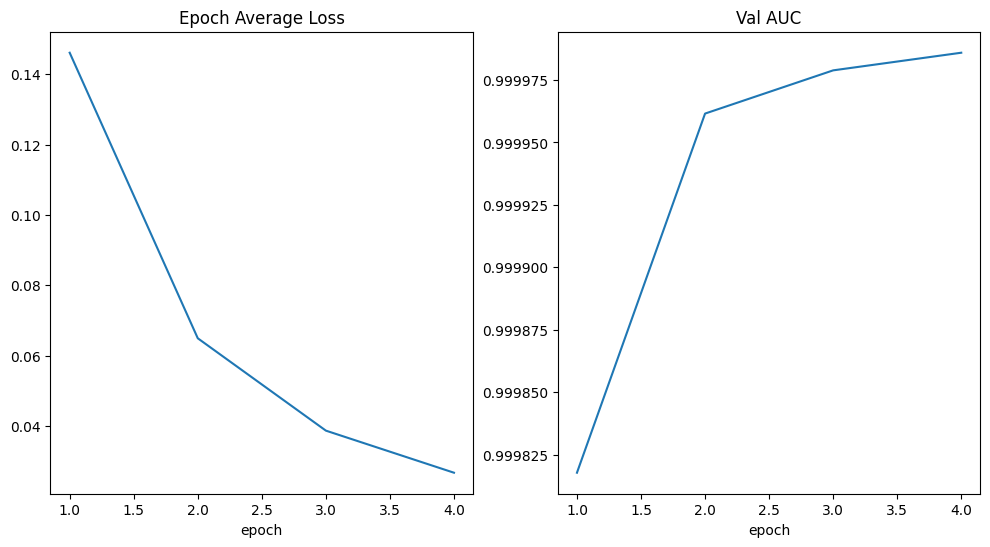

In [22]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val AUC")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

## 在测试数据集上评估模型

在训练和验证之后，我们已经在验证测试中得到了最佳模型。  
我们需要在测试数据集上评估模型，以检查它是否稳健且不过拟合。  
我们将使用这些预测生成分类报告。

希望这对你有帮助！如果你有更多问题或需要进一步的详细信息，请随时告诉我。

In [24]:
model.load_state_dict(torch.load(os.path.join(data_dir, "best_metric_model.pth")))  # Changed root_dir to data_dir
model.eval()

y_true = []
y_pred = []
with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = (
            test_data[0].to(device),
            test_data[1].to(device),
        )
        pred = model(test_images).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())


<ipython-input-24-241cf25f5516>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(data_dir, "best_metric_model.pth")))  # Change

In [ ]:
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

              precision    recall  f1-score   support

   AbdomenCT     0.9930    0.9920    0.9925       995
   BreastMRI     0.9966    0.9932    0.9949       880
         CXR     1.0000    0.9959    0.9980       982
     ChestCT     0.9912    1.0000    0.9956      1014
        Hand     0.9971    0.9914    0.9943      1048
      HeadCT     0.9929    0.9980    0.9954       976

    accuracy                         0.9951      5895
   macro avg     0.9951    0.9951    0.9951      5895
weighted avg     0.9951    0.9951    0.9951      5895



## 清理数据目录

如果使用了临时目录，请删除该目录。

希望这对你有帮助！如果你有更多问题或需要进一步的详细信息，请随时告诉我。

In [ ]:
if directory is None:
    shutil.rmtree(root_dir)